In [9]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/a/antonio-costa/BehaviorModel/utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import h5py
import delay_embedding as embed
import operator_calculations as op_calc
import clustering_methods as cl

sys.path.append('/home/a/antonio-costa/TransferOperators/bridging_scales_manuscript/utils/')
import rft_reconstruct_traj as rft

In [10]:
f = h5py.File('/bucket/StephensU/antonio/npr-1_data/resampled_results.h5','r')
print(list(f.keys()))
frameRate = np.array(f['new_frameRate'])[0]
dt= 1./frameRate
worm_labels = list(f.keys())[1:]
tseries_w=[]
for worm in worm_labels:
    ts = ma.masked_invalid(np.array(f[worm]))
    tseries_w.append(ts)
f.close()


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf,frameRate=frameRate)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('/bucket/StephensU/antonio/ForagingN2_data/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
thetas_sum = thetas_all.sum(axis=1)

['new_frameRate', 'npr-1 (ad609) on food R_2010_01_26__12_44_18___2___7', 'npr-1 (ad609)X on food  R_2010_01_25__16_08___3___10', 'npr-1 (ad609)X on food L_2010_01_22__11_33_10___2___5', 'npr-1 (ad609)X on food L_2010_01_26__12_44___3___7', 'npr-1 (ad609)X on food R_2010_01_22__11_34_25___8___5', 'npr-1 (ad609)X on food R_2010_01_22__11_35_12__5', 'npr-1 (ad609)X on food R_2010_01_26__12_44_50___4___7']


# delay embedding

In [11]:
f = h5py.File('/home/a/antonio-costa/BehaviorModel/npr-1/embedding_analysis/partition_combined_results.h5','r')
K_range = np.array(f['K_range'],dtype=int)
seed_range = np.array(f['seed_range'],dtype=int)
prob_K_s = np.array(f['probs'])
H_K_s = np.array(f['entropies'])
h_K_s = np.array(f['entropy_rates'])
Ipred_K_s = np.array(f['Ipreds'])
eps_K_s = np.array(f['eps_scale'])
f.close()

In [12]:
def std_bootstrap(l,n_times): 
    new_means = []
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    std = ma.std(new_means,axis=0)
    return ma.mean(l,axis=0),std

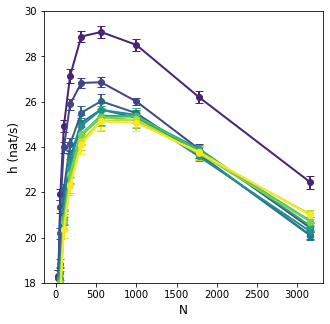

In [13]:
plt.figure(figsize=(5,5))
colors_K = plt.cm.viridis(np.linspace(.1,1,len(K_range[:22][::2])))
for k,K in enumerate(K_range[:22][::2]):
    mean,std = std_bootstrap(h_K_s[K-1,:13,:].T/dt,n_times=100)
    plt.errorbar(seed_range[:13],mean,std,c=colors_K[k],capsize=4,marker='o',lw=2)
plt.ylim(18,30)
plt.xlabel('N',fontsize=12)
plt.ylabel('h (nat/s)',fontsize=12)
# plt.savefig('h_N_Foraging_2K_N13.pdf')
plt.show()

In [ ]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_K)
cmap.set_over('0.1')
cmap.set_under('1.0')

bounds =  (K_range[:22][::2]-1)*dt
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.arange(0,1.6,.25),
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('K(s)')
# plt.savefig('colorbar_K_range_h_2K.pdf')
fig.show()


In [ ]:
8*dt

# Defining tau^*

In [ ]:
n_clusters=562

kw=0
f = h5py.File('/flash/StephensU/antonio/npr-1/tscales_noise_floor/results_{}.h5'.format(kw),'r')
delay_range = np.array(f['delay_range'])
n_clusters = np.array(f['n_clusters'],dtype=int)[0]
f.close()
n_modes=50
n_worms=7
n_shuffle=100

ts_traj_shuffle = np.zeros((n_worms,len(delay_range),n_shuffle))
eigvals_traj_shuffle = np.zeros((n_worms,len(delay_range),n_shuffle))
ts_traj_w = np.zeros((n_worms,len(delay_range),n_modes))
eigvals_traj_w = np.zeros((n_worms,len(delay_range),n_modes))
for kw in range(n_worms):
    f = h5py.File('/flash/StephensU/antonio/npr-1/tscales_noise_floor/results_{}.h5'.format(kw),'r')
    ts_traj_shuffle[kw] = np.array(f['ts_traj_shuffle'])
    eigvals_traj_shuffle[kw] = np.array(f['eigvals_traj_shuffle'])
    ts_traj_w[kw] = np.array(f['ts_traj_w'])
    eigvals_traj_w[kw] = np.array(f['eigvals_traj_w'])
    f.close()
    
tscales_shuffle_prop_single = np.vstack([-(delay_range*dt)/np.log(eigvals_traj_shuffle[kw,0,0]) for kw in range(n_worms)])

In [ ]:
n_worms=7
plt.figure(figsize=(5,5))
n_modes_plot=10
colors_ = plt.cm.Reds_r(np.linspace(0,.9,n_modes_plot))
mean,cil,ciu=stats.bootstrap(ts_traj_w[:,:,0],median=False,n_times=1000)
# plt.text(2,35,r'$|1/\Lambda_2| = {:.12f}\pm({:.2f},{:.2f}) s$'.format(mean[11],cil[11],ciu[11]))
plt.axvline(delay_range[10]*dt,c='k',ls='--')
for mode in range(n_modes_plot):
    mean,cil,ciu=stats.bootstrap(ts_traj_w[:,:,mode],median=False,n_times=100)
    plt.plot(delay_range*dt,mean,c=colors_[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])

plt.xlim(dt,20)
plt.ylim(0,40)
plt.savefig('tscales_npr1.pdf')
plt.show()


# umap_embedding

In [14]:
K_star=8
N_star=562
f = h5py.File('/flash/StephensU/antonio/BehaviorModel/npr-1/phspace_K_8_m_9.h5','r')
traj_matrix = ma.array(f['traj_matrix'])
traj_matrix[traj_matrix==0]=ma.masked
f.close()

In [15]:
import umap

def draw_umap(data,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    return u

In [16]:
sel = ~np.any(traj_matrix.mask,axis=1)
u = np.zeros((traj_matrix.shape[0],2))
data = traj_matrix[sel]
n_neighbors=15
min_dist=0.05
u[sel] = draw_umap(data,n_neighbors=n_neighbors,min_dist=min_dist,metric='chebyshev')
u[~sel] = ma.masked

In [19]:
t_rev = 6400
ts_rev = tseries_w[0][t_rev:t_rev+K_star]
t_fwd = 6010
ts_fwd = tseries_w[0][t_fwd:t_fwd+K_star]
t_ventral = 6435
ts_ventral = tseries_w[0][t_ventral:t_ventral+K_star]

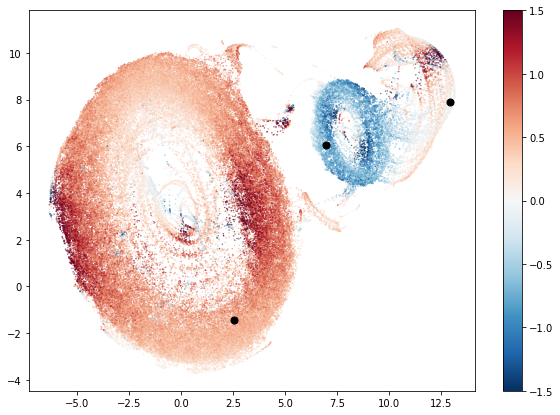

In [20]:
plt.figure(figsize=(10,7))
plt.scatter(u[:,0],u[:,1],c=omegas_all,vmax=1.5,vmin=-1.5,cmap='RdBu_r',s=.1)
plt.colorbar()
plt.scatter(u[t_fwd,0],u[t_fwd,1],c='k',s=50)
plt.scatter(u[t_rev,0],u[t_rev,1],c='k',s=50)
plt.scatter(u[t_ventral,0],u[t_ventral,1],c='k',s=50)
plt.savefig('omegas_umap_npr1.png',dpi=300)
plt.savefig('omegas_umap_npr1.pdf')
plt.show()

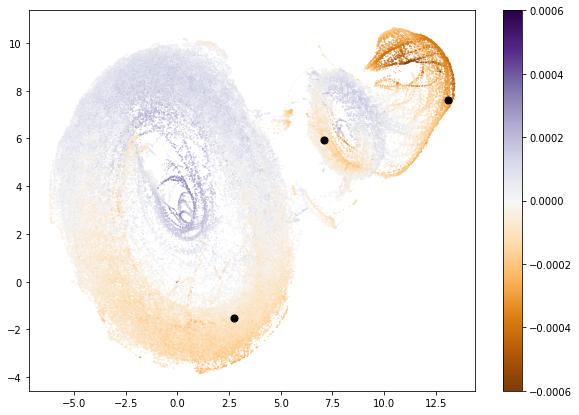

In [64]:
plt.figure(figsize=(10,7))
plt.scatter(u[:,0],u[:,1],c=thetas_sum,vmax=6e-4,vmin=-6e-4,cmap='PuOr',s=.1)
plt.colorbar()
plt.scatter(u[t_fwd,0],u[t_fwd,1],c='k',s=50)
plt.scatter(u[t_rev,0],u[t_rev,1],c='k',s=50)
plt.scatter(u[t_ventral,0],u[t_ventral,1],c='k',s=50)
plt.savefig('theta_sums_umap_npr1.png',dpi=300)
plt.savefig('theta_sums_umap_npr1.pdf')

plt.show()

In [17]:
def reconstruct_traj(ts,eigenworms_matrix,alpha=1000.):
    angleArray = ts.dot(eigenworms_matrix[:,:5].T)
    theta = -angleArray.T
    L=1
    ds = L/(theta.shape[0])
    skel = rft.get_skels(theta,L)
    X = skel[:,:,0]
    Y = skel[:,:,1]
    XCM, YCM, UX, UY, UXCM, UYCM, TX, TY, NX, NY, I, OMEG = rft.get_RBM(skel,L,ds,dt)
    DX, DY, ODX, ODY, VX, VY, Xtil, Ytil, THETA = rft.subtractRBM(X, Y, XCM, YCM, UX, UY, UXCM, UYCM, OMEG, dt)
    TX,TY = rft.lab2body(TX, TY, THETA)
    VX,VY = rft.lab2body(VX, VY, THETA)
    RBM = rft.posture2RBM(TX,TY,Xtil,Ytil,VX,VY,L,I,ds,alpha)
    XCM_recon,YCM_recon,THETA_recon = rft.integrateRBM(RBM,dt,THETA)
    Xskel_recon,Yskel_recon =  rft.addRBMRotMat(Xtil, Ytil, XCM_recon, YCM_recon,THETA_recon, XCM, YCM, THETA)
    return Xskel_recon,Yskel_recon

In [27]:
alpha=1000.
Xskel_recon,Yskel_recon=reconstruct_traj(ts_rev,eigenworms_matrix)


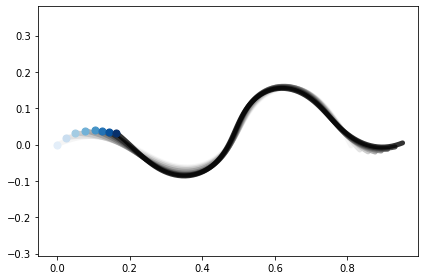

In [67]:
colors_t = plt.cm.Greys(np.linspace(0.1,1,len(ts_rev)))
colors_head = plt.cm.Blues(np.linspace(0.1,1,len(ts_rev)))

for kt in range(len(Xskel_recon)):
    plt.plot(np.array(Xskel_recon)[kt],np.array(Yskel_recon)[kt],c=colors_t[kt],lw=5,alpha=.8,solid_capstyle='round')
    plt.scatter(np.array(Xskel_recon)[kt][0],np.array(Yskel_recon)[kt][0],color=colors_head[kt],s=50,zorder = len(Xskel_recon)+1)
plt.axis('equal')
plt.tight_layout()
plt.savefig('rev_traj.pdf')
plt.show()

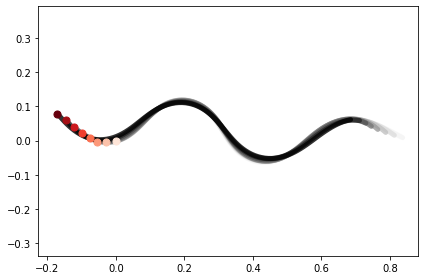

In [68]:
Xrecon,Yrecon=reconstruct_traj(ts_fwd,eigenworms_matrix)
colors_t = plt.cm.Greys(np.linspace(0.1,1,len(ts_fwd)))
colors_head = plt.cm.Reds(np.linspace(0.1,1,len(ts_fwd)))

for kt in range(len(Xrecon)):
    plt.plot(np.array(Xrecon)[kt],np.array(Yrecon)[kt],c=colors_t[kt],lw=5,alpha=.8,solid_capstyle='round')
    plt.scatter(np.array(Xrecon)[kt][0],np.array(Yrecon)[kt][0],color=colors_head[kt],s=50,zorder = len(Xrecon)+1)
plt.axis('equal')
plt.tight_layout()
plt.savefig('fwd_traj.pdf')
plt.show()

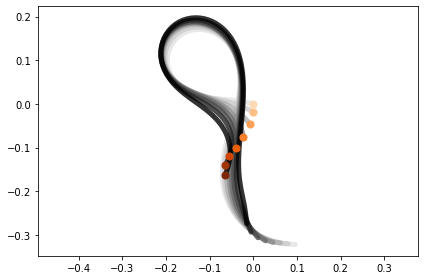

In [60]:
Xrecon,Yrecon=reconstruct_traj(ts_ventral,eigenworms_matrix)
colors_t = plt.cm.Greys(np.linspace(0.2,1,len(ts_ventral)))
colors_head = plt.cm.Oranges(np.linspace(0.2,1,len(ts_ventral)))
for kt in range(len(Xrecon)):
    plt.plot(np.array(Xrecon)[kt],np.array(Yrecon)[kt],c=colors_t[kt],lw=5,alpha=.8,solid_capstyle='round')
    plt.scatter(np.array(Xrecon)[kt][0],np.array(Yrecon)[kt][0],color=colors_head[kt],s=50,zorder = len(Xrecon)+1)
plt.axis('equal')
plt.tight_layout()
plt.savefig('ventral_traj.pdf')
plt.show()


# Recover phi2 dynamics

In [17]:
n_clusters=562
f = h5py.File('/flash/StephensU/antonio/BehaviorModel/npr-1/labels_K_8_N_562.h5','r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
f.close()

labels_traj[mask_traj] = ma.masked

delay=10
ctraj_path = '/flash/StephensU/antonio/BehaviorModel/npr-1/ctrajs_562_clusters_delay_{}/'.format(delay)
f = h5py.File(ctraj_path+'/c_traj.h5','r')
mD = f['MetaData']
n_clusters = np.array(mD['n_clusters'],dtype=int)[0]
delay = np.array(mD['delay'],dtype=int)[0]
ctraj = ma.array(f['ctraj'])
mask = ma.array(f['ctraj_mask'])
ctraj[mask==1] = ma.masked
kmeans_labels = np.array(f['kmeans_labels'])
final_labels = ma.array(f['final_labels'],dtype=int)
final_labels[labels_traj.mask] = ma.masked
f.close()

In [18]:
# delay=10
# lcs,P = op_calc.transition_matrix(labels_traj,delay,return_connected=True)
# final_labels = op_calc.get_connected_labels(labels_traj,lcs)
# n_modes=10
# inv_measure = op_calc.stationary_distribution(P)
# R = op_calc.get_reversible_transition_matrix(P)
# eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
# sorted_indices = np.argsort(eigvals.real)[::-1]
# eigvals = eigvals[sorted_indices][1:].real
# eigvals[np.abs(eigvals-1)<1e-12] = np.nan
# eigvals[eigvals<1e-12] = np.nan
# eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
# eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
# eigfunctions_traj[final_labels.mask] = ma.masked
# phi2 = eigfunctions[:,1]

In [19]:
# plt.plot(eigfunctions_traj[:,1])
# plt.show()

In [20]:
# thresh_range,rho_c,c_thresh,kmeans_labels = op_calc.optimal_partition(eigfunctions[:,1],inv_measure,P,return_rho=True)
# phi2_traj = eigfunctions_traj[:,1]

In [21]:
# sel = eigfunctions[:,1]<=c_thresh
# c_negative = np.linspace(-2,0,sel.sum())
# d_neg = {}
# for k in range(c_negative.shape[0]):
#     d_neg[np.sort(eigfunctions[sel,1])[k]] = c_negative[k]

# sel = eigfunctions[:,1]>=c_thresh
# c_positive = np.linspace(0,2,sel.sum())
# d_pos = {}
# for k in range(c_positive.shape[0]):
#     d_pos[np.sort(eigfunctions[sel,1])[k]] = c_positive[k]
# ctraj = ma.zeros(phi2_traj.shape[0])
# sel = np.logical_and(phi2_traj<c_thresh,~phi2_traj.mask)
# ctraj[sel] = np.array([d_neg[kc] for kc in phi2_traj[sel]])
# sel = np.logical_and(phi2_traj>=c_thresh,~phi2_traj.mask)
# ctraj[sel] = np.array([d_pos[kc] for kc in phi2_traj[sel]])
# sel_mask = phi2_traj.mask
# ctraj[sel_mask] = ma.masked


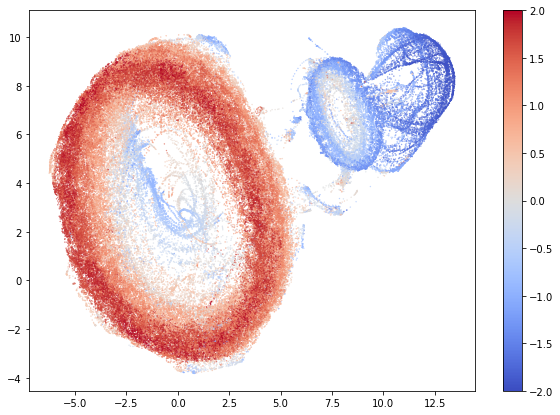

In [43]:
from matplotlib.colors import DivergingNorm
plt.figure(figsize=(10,7))
vmin,vmax=-2,2
plt.scatter(u[:,0],u[:,1],c=ctraj,norm=DivergingNorm(0,vmin=vmin,vmax=vmax),cmap='coolwarm',s=.1)
plt.colorbar()
plt.savefig('phi2_umap_npr1.png',dpi=300)
plt.savefig('phi2_umap_npr1.pdf')

plt.show()

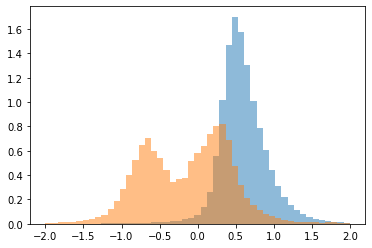

In [35]:
plt.hist(omegas_all[ctraj>0].compressed(),bins=np.linspace(-2,2),density=True,alpha=.5)
plt.hist(omegas_all[ctraj<0].compressed(),bins=np.linspace(-2,2),density=True,alpha=.5)
plt.show()

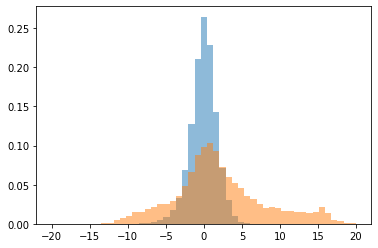

In [38]:
plt.hist(a3s_all[ctraj>0].compressed(),bins=np.linspace(-20,20,50),density=True,alpha=.5)
plt.hist(a3s_all[ctraj<0].compressed(),bins=np.linspace(-20,20,50),density=True,alpha=.5)
plt.show()

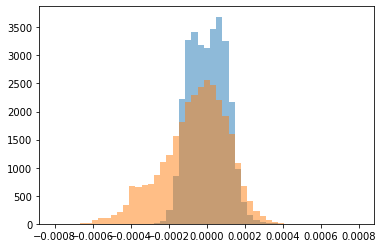

In [40]:
plt.hist(thetas_sum[ctraj>0].compressed(),bins=np.linspace(-8e-4,8e-4,50),density=True,alpha=.5)
plt.hist(thetas_sum[ctraj<0].compressed(),bins=np.linspace(-8e-4,8e-4,50),density=True,alpha=.5)
plt.show()

In [23]:
from lmfit import minimize, Parameters, Parameter, report_fit

def fit_tscales(x,y,b0=10,d0=50):
    
    def fcn2(params,x,data):
        a=params['a'].value
        b=params['b'].value
        c=params['c'].value
        d=params['d'].value
        #Fits the drift

        return (a*np.exp(-x/b) + c * np.exp(-x/d) - data)

    params = Parameters()
    params.add('a',   value= 1)
    params.add('b', value= b0,min=0)
    params.add('c', value= 1)
    params.add('d', value= d0,min=0)

    # do fit, here with leastsq model
    result = minimize(fcn2, params, args=(x,y))
    
    p1 = result.params['a'].value
    p2 = result.params['b'].value
    p3 = result.params['c'].value
    p4 = result.params['d'].value
    tscales = np.array([p2,p4])
    stderrs = np.array([result.params['b'].stderr,result.params['d'].stderr])
    
    return p1,p2,p3,p4,tscales,stderrs

def func2(x, a, b, c, d):
    return a * np.exp(-x/b) + c * np.exp(-x/d) 

In [24]:
def state_lifetime(states):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries)))
    return durations

In [25]:
n_worms = len(tseries_w)
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked
cluster_traj_w = []
ctraj_w = []
t0 = 0
for kw in range(n_worms):
    cluster_traj_w.append(cluster_traj[t0:t0+len(tseries_w[kw])])
    ctraj_w.append(ctraj[t0:t0+len(tseries_w[kw])])
    t0+=len(tseries_w[kw])

In [26]:
stride = int(delay/2)
# stride=1
dts_w=[]
for kw,labels_here in enumerate(cluster_traj_w):
    dts = np.hstack(state_lifetime(labels_here[::stride]))*dt*stride
    dts_w.append(dts)

In [27]:
def get_errorbar_dist(lifetimes_w,t0,tf):
    all_lt = np.hstack(lifetimes_w)
    x,y = stats.complementary_cumulative_dist(all_lt,(t0,tf))
    y_all = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x_all = np.sort(np.unique(x))
    
    dict_y = {}
    for x_ in x_all:
        dict_y[x_] = []

    for k in range(100):
        x,y = stats.cumulative_dist(np.hstack(np.random.choice(lifetimes_w,len(lifetimes_w))),(t0,tf))
        y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
        x = np.sort(np.unique(x))
        for kx in range(len(y)):
            dict_y[x[kx]].append(y[kx])
        if k%10==0:
            print(k)
            
    y_errorbars = np.zeros((len(dict_y.keys()),3))
    for kx,x_ in enumerate(x_all):
        values = np.array(dict_y[x_])
        values = values[values>0]
        cil = np.percentile(values,2.5)
        ciu = np.percentile(values,97.5)
        y_errorbars[kx] = [y_all[kx],cil,ciu]
    return x_all,y_errorbars

In [28]:
t0,tf = 0,5000
# t0,tf = 0,1000
all_lt = np.hstack(dts_w)
x,y = stats.complementary_cumulative_dist(all_lt,(t0,tf))
y_all = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
x_all = np.sort(np.unique(x))

p1,p2,p3,p4,tscales,stderrs = fit_tscales(x_all,y_all,b0=.5,d0=10)
params_all = np.array([p1,p2,p3,p4])
sorted_indices = np.argsort(tscales)[::-1]
tscales_all = tscales[sorted_indices]

dict_y = {}
for x_ in x_all:
    dict_y[x_] = []

In [29]:
tscales_bootstrap = []
params_bootstrap = []
rates_bootstrap = []
for k in range(1000):
    x,y = stats.complementary_cumulative_dist(np.hstack(np.random.choice(dts_w,len(dts_w))),(t0,tf))
    y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x = np.sort(np.unique(x))
    p1,p2,p3,p4,tscales,stderrs = fit_tscales(x,y,b0=1,d0=25)
    params_bootstrap.append(np.array([p1,p2,p3,p4]))
    sorted_indices = np.argsort(tscales)[::-1]
    tscales = tscales[sorted_indices]
    tscales_bootstrap.append(tscales)
    rates_bootstrap.append((1/tscales).sum())
    for kx in range(len(y)):
        dict_y[x[kx]].append(y[kx])

In [30]:
y_errorbars = np.zeros((len(dict_y.keys()),3))
for kx,x_ in enumerate(x_all):
    values = np.array(dict_y[x_])
    values = values[values>0]
    cil = np.percentile(values,2.5)
    ciu = np.percentile(values,97.5)
    y_errorbars[kx] = [y_all[kx],cil,ciu]

In [31]:
tscales_cil = np.percentile(np.vstack(tscales_bootstrap),2.5,axis=0)
tscales_ciu = np.percentile(np.vstack(tscales_bootstrap),97.5,axis=0)

rates_cil = np.percentile(np.vstack(rates_bootstrap),2.5,axis=0)
rates_ciu = np.percentile(np.vstack(rates_bootstrap),97.5,axis=0)

params_cil = np.percentile(params_bootstrap,2.5,axis=0)
params_ciu = np.percentile(params_bootstrap,97.5,axis=0)

p1,p2,p3,p4 = params_all
curvey = func2(x_all,p1,p2,p3,p4)

p1,p2,p3,p4 = params_cil
curvey_cil = func2(x_all,p1,p2,p3,p4)

p1,p2,p3,p4 = params_ciu
curvey_ciu = func2(x_all,p1,p2,p3,p4)

In [32]:
lambda_rec = 1/(1/tscales_all[0]+1/tscales_all[1])
lambda_rec_cil = np.percentile(1/np.sum(1/np.vstack(tscales_bootstrap),axis=1),2.5)
lambda_rec_ciu = np.percentile(1/np.sum(1/np.vstack(tscales_bootstrap),axis=1),97.5)

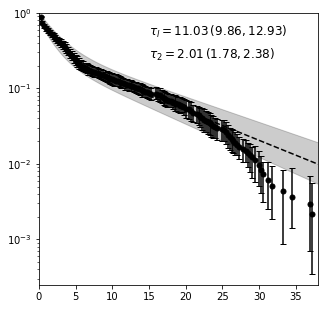

In [33]:
plt.figure(figsize=(5,5))
plt.errorbar(x_all,y_errorbars[:,0],yerr = [y_errorbars[:,0]-y_errorbars[:,1],y_errorbars[:,2]-y_errorbars[:,0]],fmt='o',ms=5,capsize=3,c='k')
plt.plot(x_all,curvey,c='k',ls='--')
plt.fill_between(x_all,curvey_cil,curvey_ciu,color='k',alpha=.2)
plt.ylim(2.5e-4,1)
plt.yscale('log')
plt.xlim(0,38)
plt.text(15,.5,r'$\tau_l = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[0],tscales_cil[0],tscales_ciu[0]),fontsize=12)
plt.text(15,.25,r'$\tau_2 = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[1],tscales_cil[1],tscales_ciu[1]),fontsize=12)
# plt.text(30,.1,.r'$1/\Lambda = {:.2f}\,({:.2f},{:.2f})$'.format(lambda_rec,lambda_rec_cil,lambda_rec_ciu),fontsize=12)
# plt.savefig('dwell_times_npr-1_{}_{}_delay_{}_with_errorbars.pdf'.format(t0,tf,delay))
plt.show()

In [34]:
lags_max = np.max([len(ctraj_w[kw]) for kw in range(n_worms)])
lags = np.unique(np.array(np.logspace(0,np.log10(lags_max),5000),dtype=int))
C_w=ma.zeros((n_worms,len(lags)))
for kw in range(n_worms):
    sel = lags<len(ctraj_w[kw])
    C_est = ma.zeros(len(lags))
    C_est[sel] = stats.acf(ctraj_w[kw],lags[sel])
    C_est[~sel] = ma.masked
    C_w[kw] = C_est
# plt.plot(stats.acf(ctraj_w[0]))
# plt.plot()

In [35]:
C_w = ma.masked_invalid(C_w)
C_w[C_w==0] = ma.masked

mean,cil,ciu=stats.bootstrap(C_w,n_times=100)

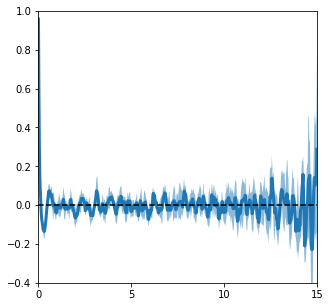

In [37]:
plt.figure(figsize=(5,5))
plt.plot(lags*dt/60,mean,lw=3)
plt.fill_between(lags*dt/60,cil,ciu,alpha=.5)
plt.axhline(0,ls='--',c='k')
# plt.xlim(0,1.5)
plt.xticks(np.arange(0,16,5))
plt.xlim(0,15)
plt.ylim(-.4,1)
# plt.savefig('acf_npr-1_all.pdf')
plt.show()


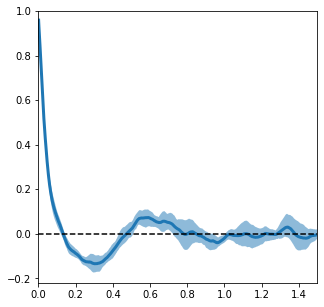

In [38]:
plt.figure(figsize=(5,5))
plt.plot(lags*dt/60,mean,lw=3)
plt.fill_between(lags*dt/60,cil,ciu,alpha=.5)
plt.axhline(0,ls='--',c='k')
plt.xlim(0,1.5)
plt.ylim(-.22,1)
# plt.savefig('acf_npr-1_zoomin.pdf')
plt.show()

#  pirouette rate time

In [39]:
wsize = int(3*60*frameRate)

In [40]:
cluster_traj_w = []
t0=0
for kw in range(len(tseries_w)):
    cluster_traj_w.append(cluster_traj[t0:t0+len(tseries_w[kw])])
    t0+=len(tseries_w[kw])

In [41]:
#indices 0 and 1 might be shuffled due to the diagonalization of the Pij matrix
window_t0s = np.arange(0,len(cluster_traj_w[kw]),wsize) 
pir_rate_w=np.zeros((len(tseries_w),5))
run_rate_w = np.zeros((len(tseries_w),5))
for kw in range(len(tseries_w)):
    pir_rate_w[kw] = [np.sum(cluster_traj_w[kw][t0:t0+wsize]==1)/(ma.count(cluster_traj_w[kw][t0:t0+wsize])) for t0 in window_t0s]
    run_rate_w[kw] = [np.sum(cluster_traj_w[kw][t0:t0+wsize]==0)/(ma.count(cluster_traj_w[kw][t0:t0+wsize])) for t0 in window_t0s]

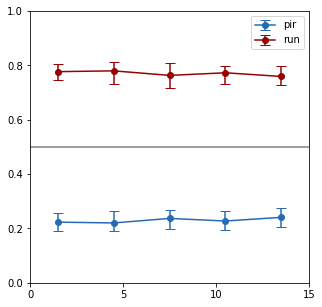

In [42]:
plt.figure(figsize=(5,5))
mean,cil,ciu = stats.bootstrap(pir_rate_w,n_times=100)
plt.errorbar((window_t0s+wsize/2)/(frameRate*60),mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',c='#276ab3',label='pir')
mean,cil,ciu = stats.bootstrap(run_rate_w,n_times=100)
plt.errorbar((window_t0s+wsize/2)/(frameRate*60),mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',c='#980002',label='run')
# plt.ylim(6,14)
plt.legend()
plt.xlim(0,15)
plt.xticks(np.arange(0,16,5))
plt.axhline(0.5,c='gray')

plt.ylim(0,1)
plt.savefig('p_states.pdf')
plt.show()

In [43]:
#indices 0 and 1 might be shuffled due to the diagonalization of the Pij matrix
wsize = int(3*60*frameRate)
window_t0s = np.arange(0,len(cluster_traj_w[kw]),wsize) 
trans_rate1_w=np.zeros((len(tseries_w),5))
trans_rate2_w=np.zeros((len(tseries_w),5))
wtrans_w = np.zeros((len(tseries_w),5))
for kw in range(len(tseries_w)):
    for kt,t0 in enumerate(window_t0s):
        P = op_calc.transition_matrix(cluster_traj_w[kw][t0:t0+wsize],delay)
        trans_rate1_w[kw,kt] = P.todense()[0,1]
        trans_rate2_w[kw,kt] = P.todense()[1,0]
        eigvals,eigvecs = np.linalg.eig(P.todense())
        wtrans_w[kw,kt] = -(delay*dt)/np.log(eigvals.min())

In [44]:
wtrans_w.mean(axis=0)

array([1.78983374, 1.95027703, 1.93116446, 1.83741373, 1.91478968])

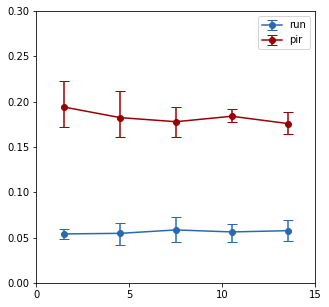

In [45]:
plt.figure(figsize=(5,5))
mean,cil,ciu = stats.bootstrap(trans_rate1_w,n_times=100)
plt.errorbar((window_t0s+wsize/2)/(frameRate*60),mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',c='#276ab3',label='run')
mean,cil,ciu = stats.bootstrap(trans_rate2_w,n_times=100)
plt.errorbar((window_t0s+wsize/2)/(frameRate*60),mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',c='#980002',label='pir')
# plt.ylim(6,14)
plt.legend()
plt.xlim(0,15)
plt.xticks(np.arange(0,16,5))
# plt.axhline(0.5,c='gray')
plt.ylim(0,.3)
# plt.savefig('p_trans_states.pdf')
plt.show()

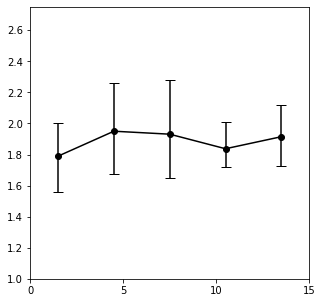

In [46]:
plt.figure(figsize=(5,5))
mean,cil,ciu = stats.bootstrap(wtrans_w,n_times=100)
plt.errorbar((window_t0s+wsize/2)/(frameRate*60),mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',c='k')
plt.xlim(0,15)
plt.xticks(np.arange(0,16,5))
# plt.axhline(0.5,c='gray')
plt.ylim(1,2.75)
# plt.savefig('wtrans_states.pdf')
plt.show()

In [47]:
lambda_w = np.zeros(n_worms)
for kw in range(n_worms):
    P = op_calc.transition_matrix(cluster_traj_w[kw],delay)
    eigvals,eigvecs = np.linalg.eig(P.todense())
    lambda_w[kw] = -(delay*dt)/np.log(eigvals.min())


In [48]:
mean_w,cil_w,ciu_w = stats.bootstrap(lambda_w,n_times=100)

In [49]:
mean_w,cil_w,ciu_w

(1.8615394903255973,
 masked_array(data=[1.7639711744344684],
              mask=[False],
        fill_value=1e+20),
 masked_array(data=[2.0216313737213674],
              mask=[False],
        fill_value=1e+20))

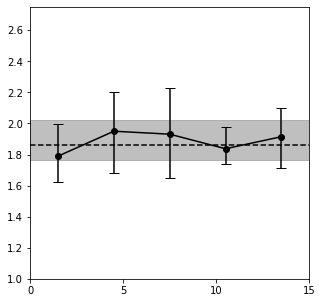

In [50]:
plt.figure(figsize=(5,5))
plt.axhline(mean_w,c='k',ls='--')
plt.axhspan(cil_w,ciu_w,color='gray',alpha=.5)
mean,cil,ciu = stats.bootstrap(wtrans_w,n_times=100)
plt.errorbar((window_t0s+wsize/2)/(frameRate*60),mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',c='k')
plt.xlim(0,15)
plt.xticks(np.arange(0,16,5))
# plt.axhline(0.5,c='gray')
plt.ylim(1,2.75)
# plt.savefig('wtrans_states.pdf')
plt.show()